#### Imports

In [36]:
import warnings
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, precision_score,f1_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [37]:
# Styling
sns.set(style="whitegrid")
pd.set_option('future.no_silent_downcasting', True)
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings("ignore")

#### Load Dataframe

In [38]:
df = pd.read_csv('https://zhang-datasets.s3.us-east-2.amazonaws.com/telcoChurn.csv')

#### Head

In [39]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Info

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Description

In [41]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#### Missing Values

In [42]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Data Types

In [43]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Data Cleaning

In [44]:
df.columns = df.columns.str.strip()
df = df.copy()
# TotalCharges should be numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['TotalCharges'].isnull().sum()
df = df.dropna(subset=['TotalCharges'])

## Target Variable Distribution

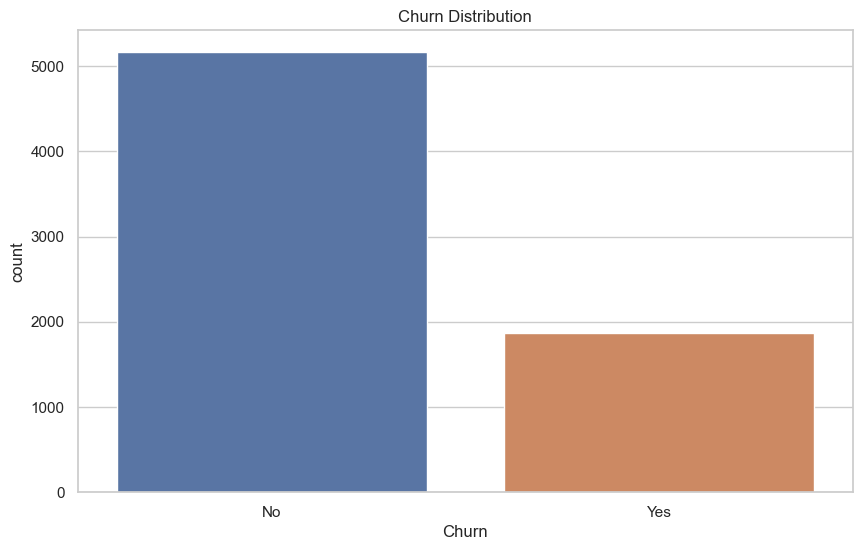

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [58]:
sns.countplot(data=df, x='Churn', palette='deep', hue='Churn')
plt.title("Churn Distribution")
plt.show()

print(df['Churn'].value_counts(normalize=True))


## Categorical Features Exploration

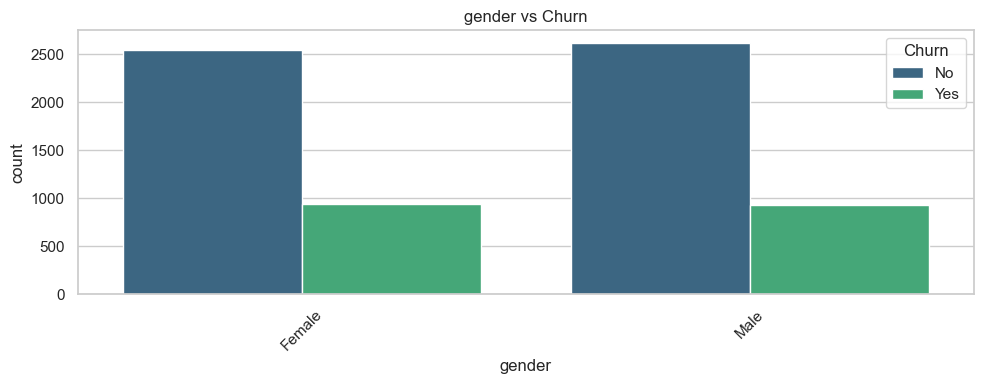

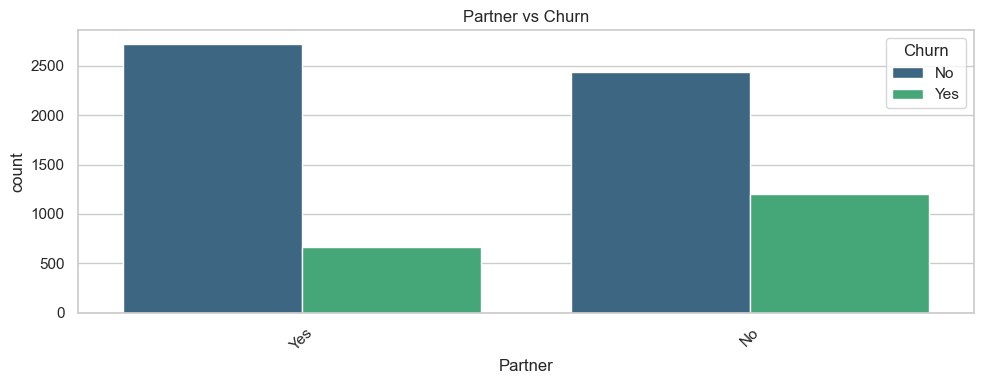

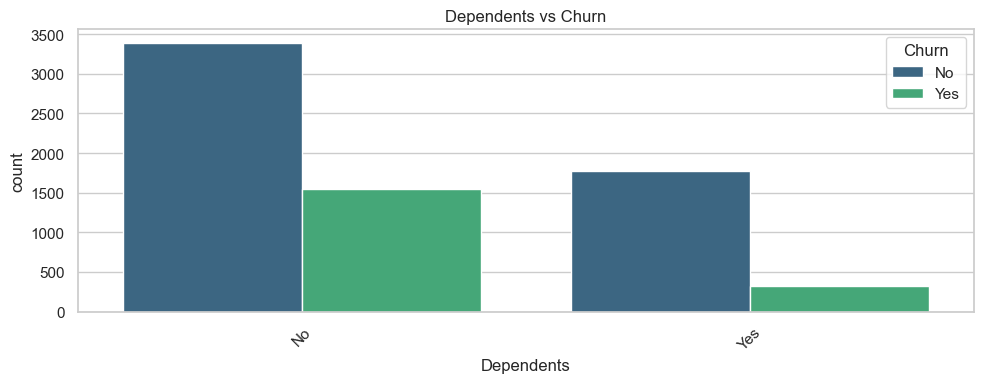

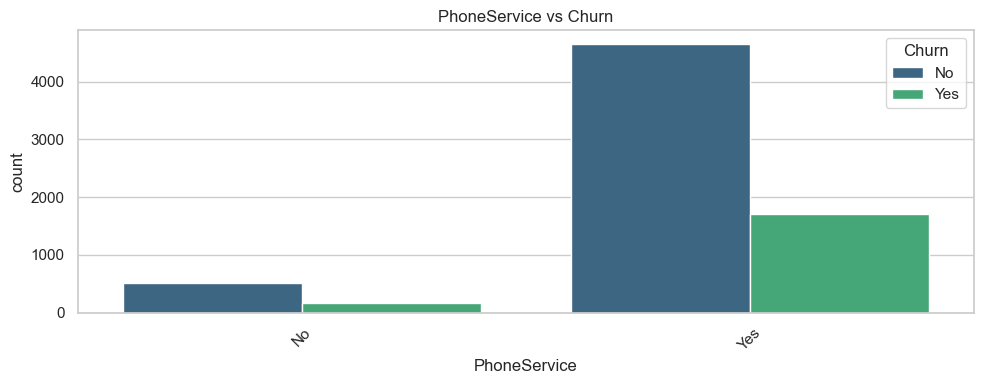

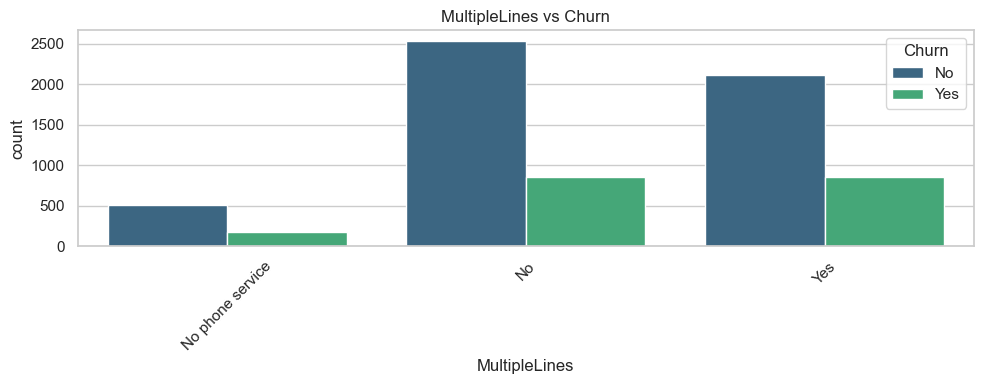

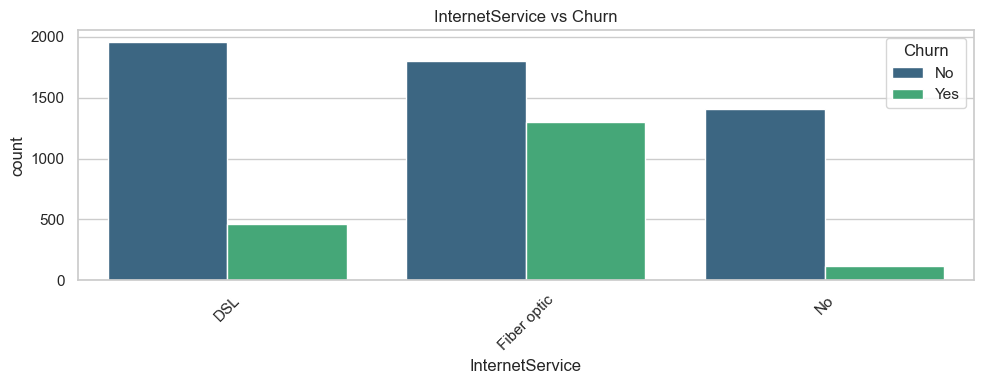

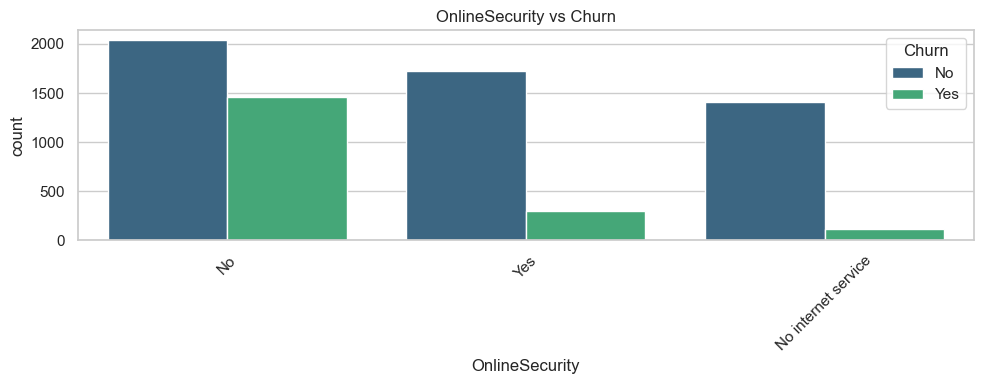

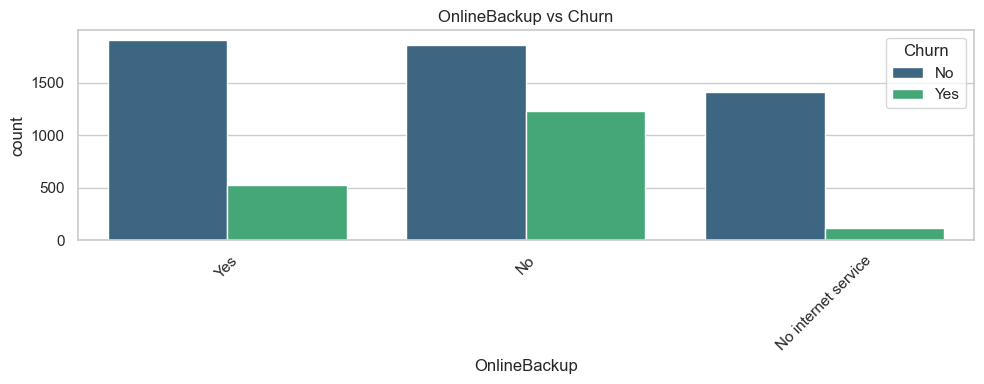

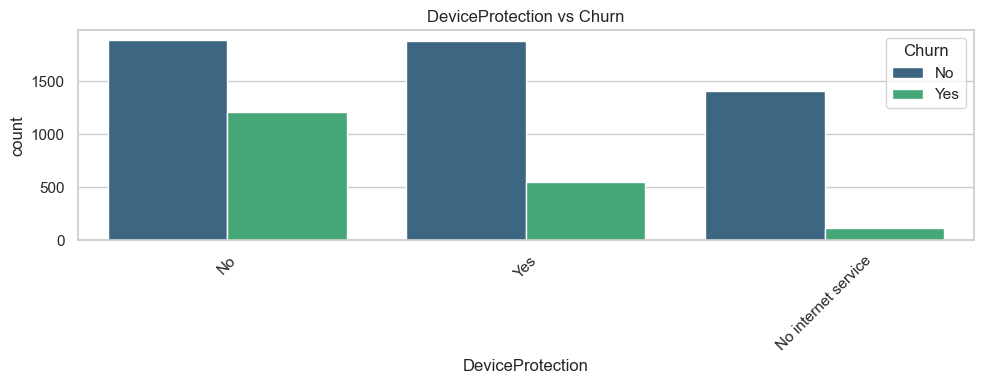

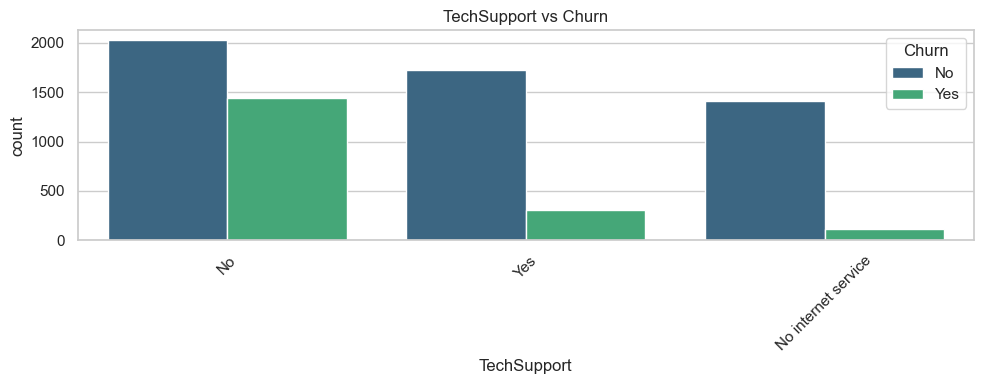

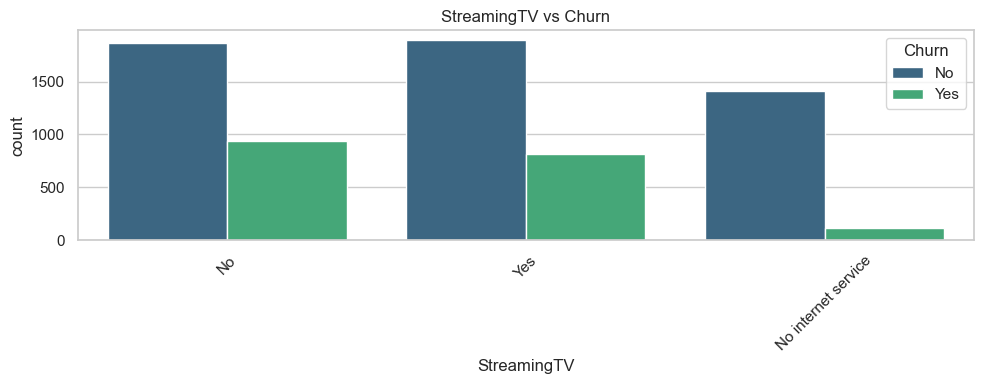

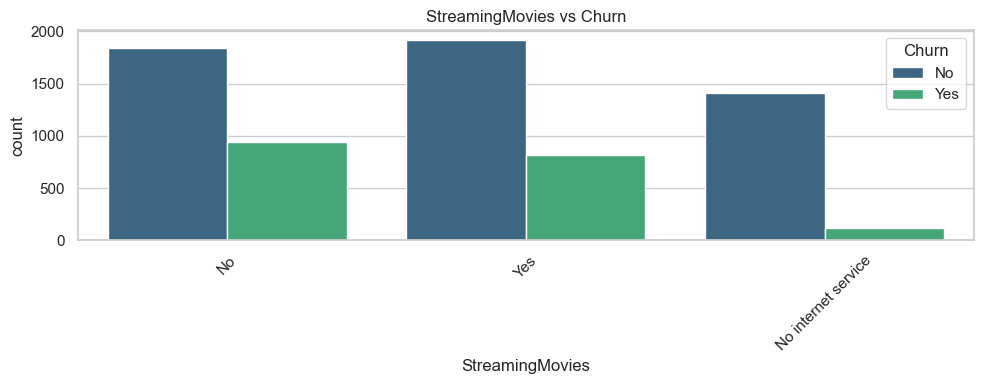

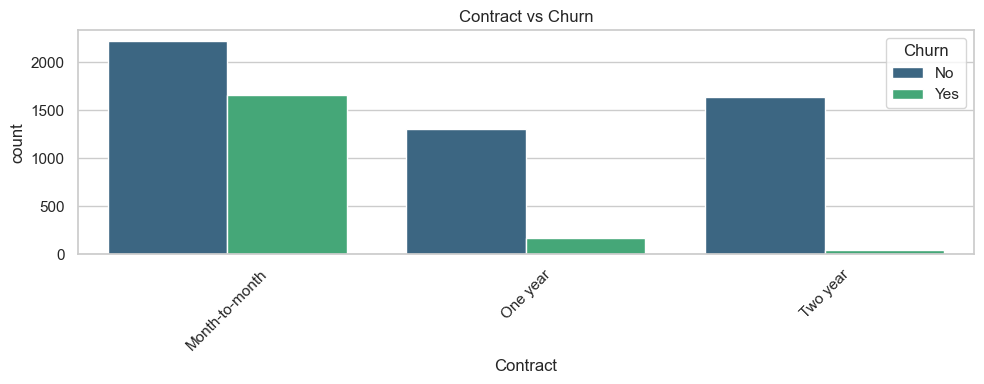

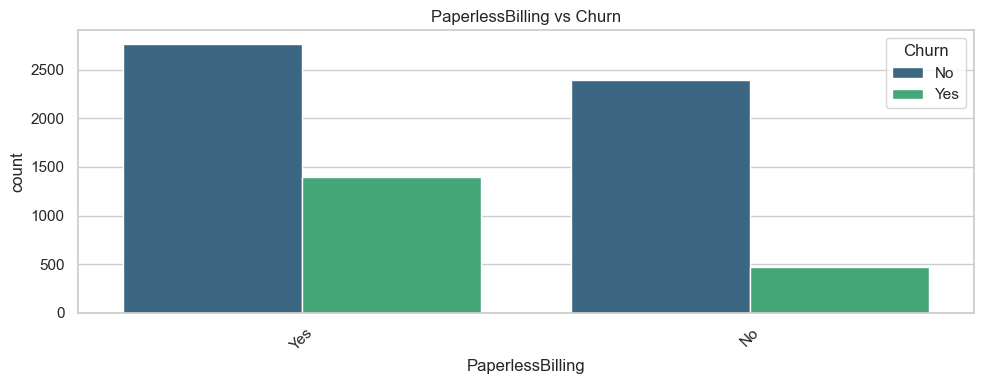

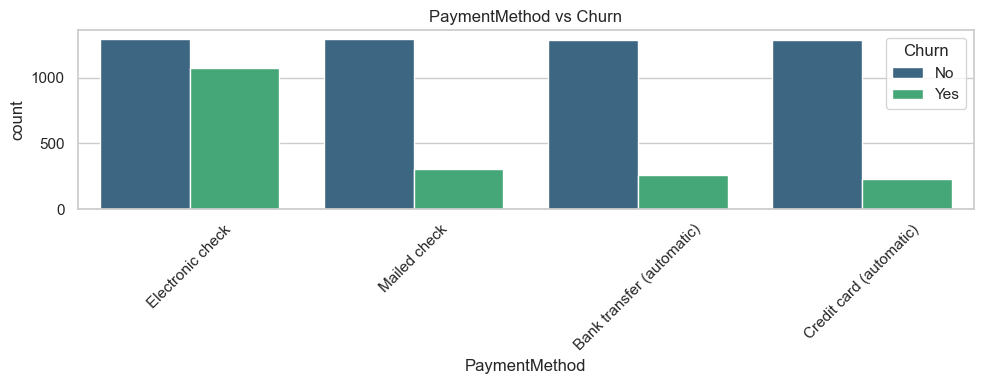

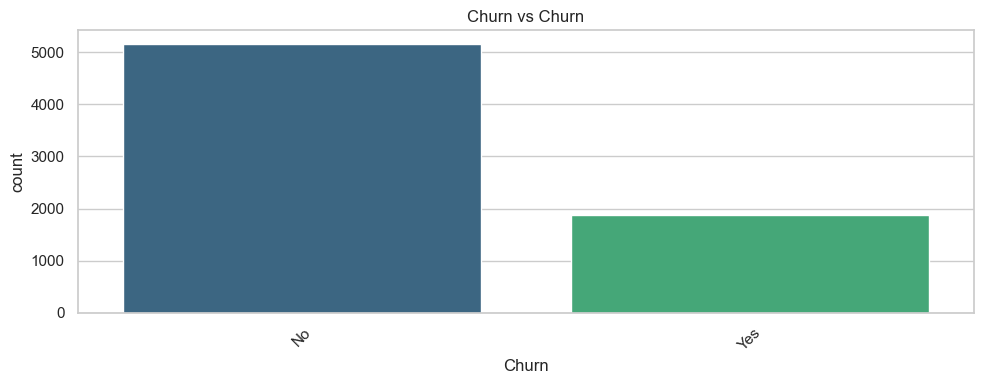

In [46]:
cat_features = [col for col in df.select_dtypes(include=['object']).columns.tolist() if col != 'customerID']

for col in cat_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, hue='Churn', palette='viridis')
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Numerical Feature Exploration

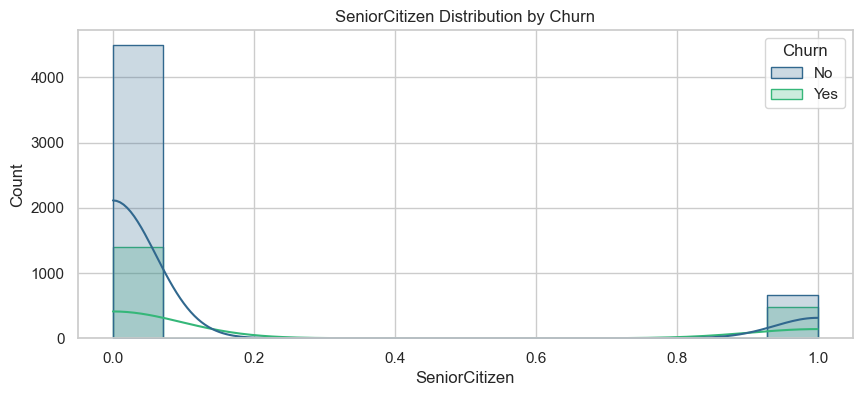

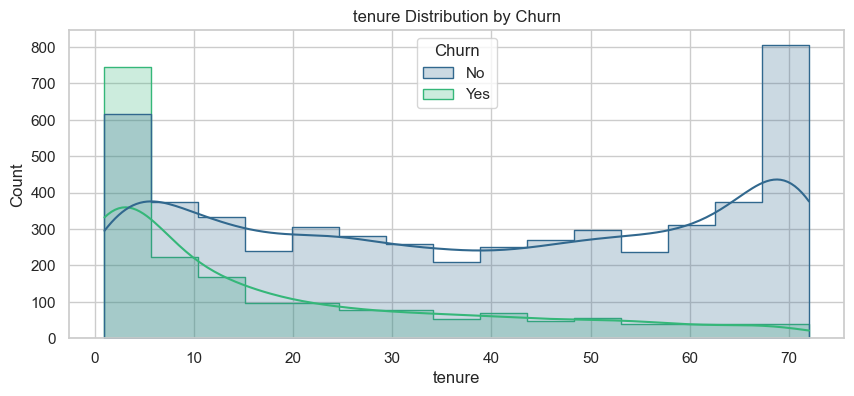

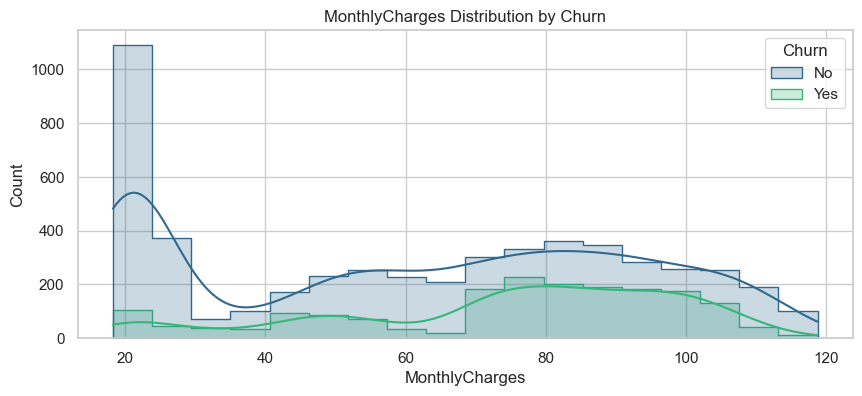

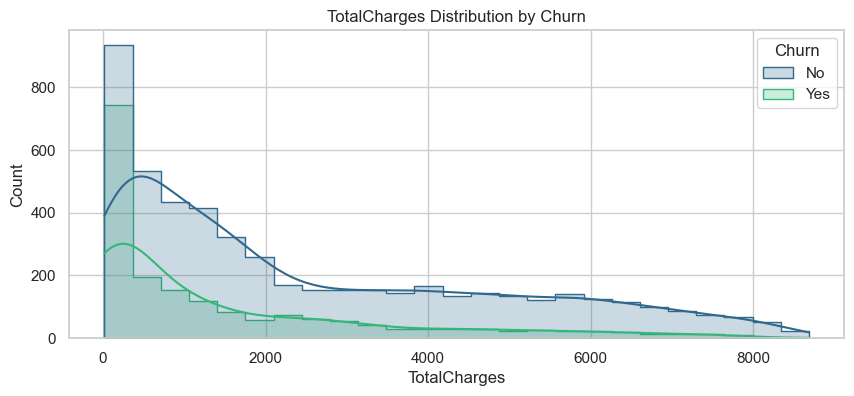

In [47]:
num_features = df.select_dtypes(include=['number']).columns.tolist()

for col in num_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step", palette='viridis')
    plt.title(f'{col} Distribution by Churn')
    plt.show()


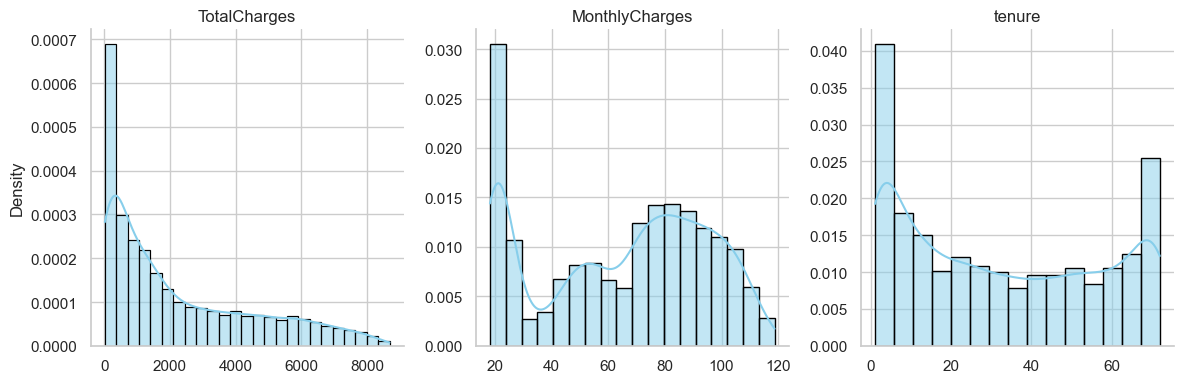

In [48]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Melt for grid plotting
df_melted = df[['TotalCharges','MonthlyCharges','tenure']].melt()

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="value", kde=True, stat="density", color="skyblue", edgecolor="black")
g.set_titles("{col_name}")
g.set_axis_labels("", "Density")

plt.tight_layout()
plt.show()

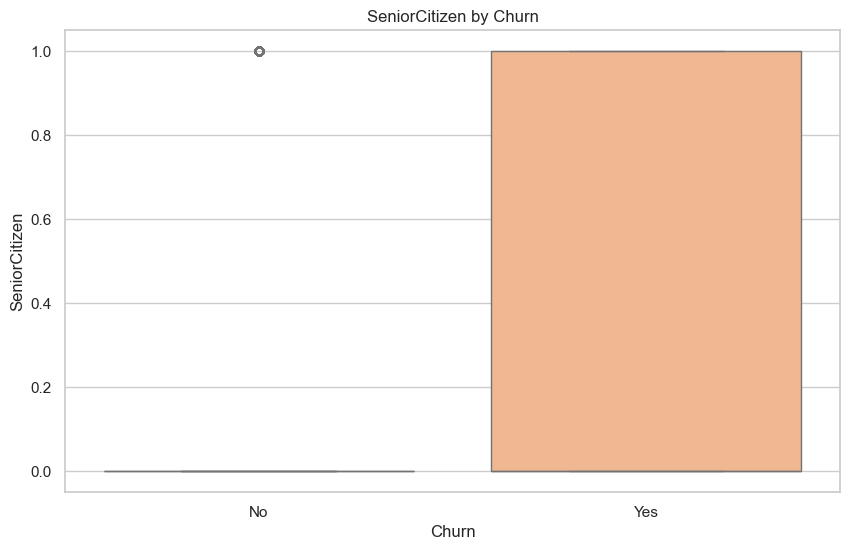

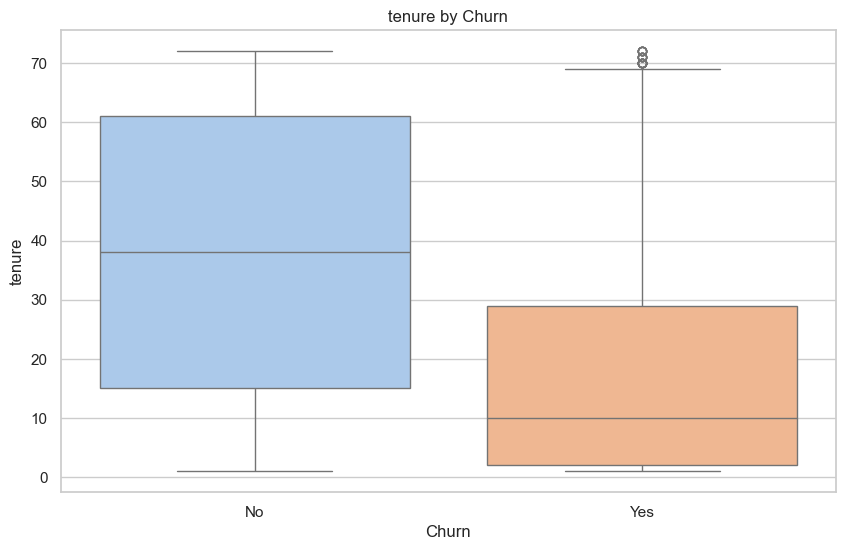

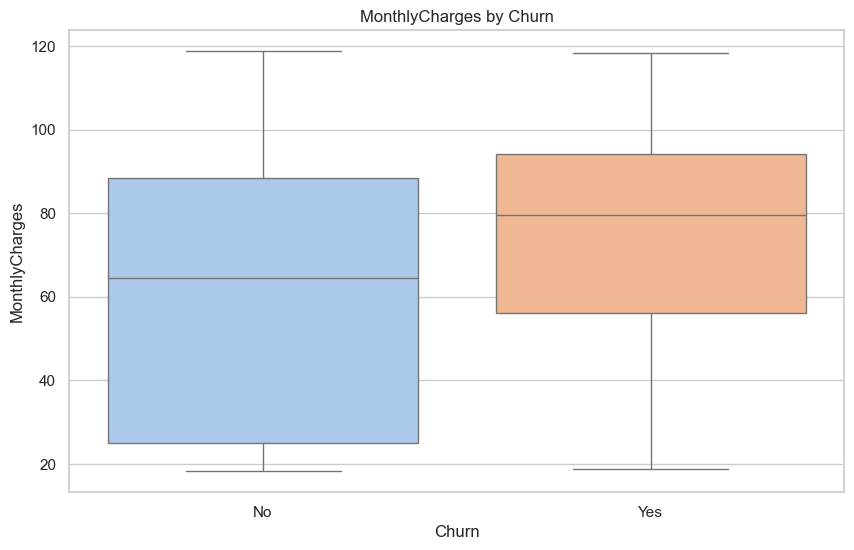

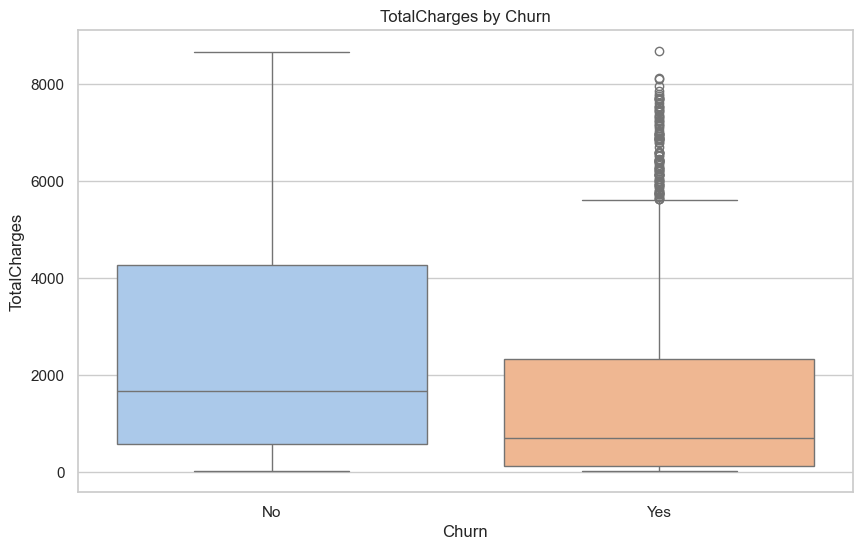

In [49]:
for col in num_features:
    sns.boxplot(data=df, x='Churn', y=col, hue='Churn', palette='pastel')
    plt.title(f'{col} by Churn')
    plt.show()

## Correlation Map

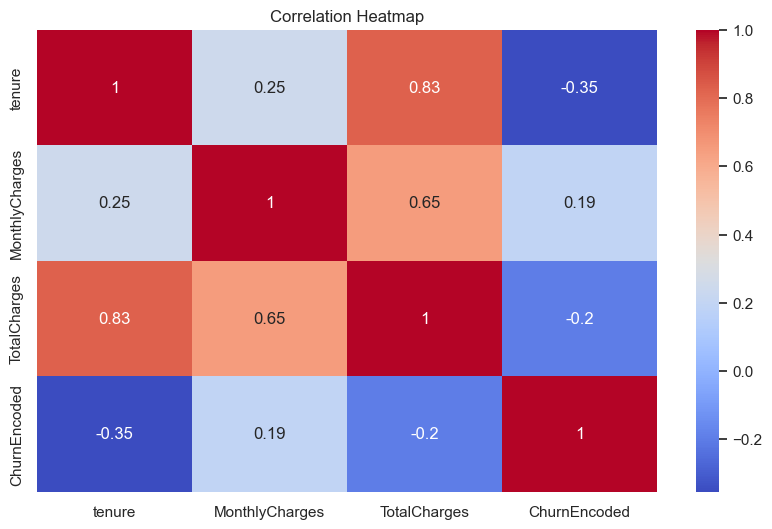

In [50]:
df['ChurnEncoded'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Correlation matrix
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnEncoded']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Tenure Bucket

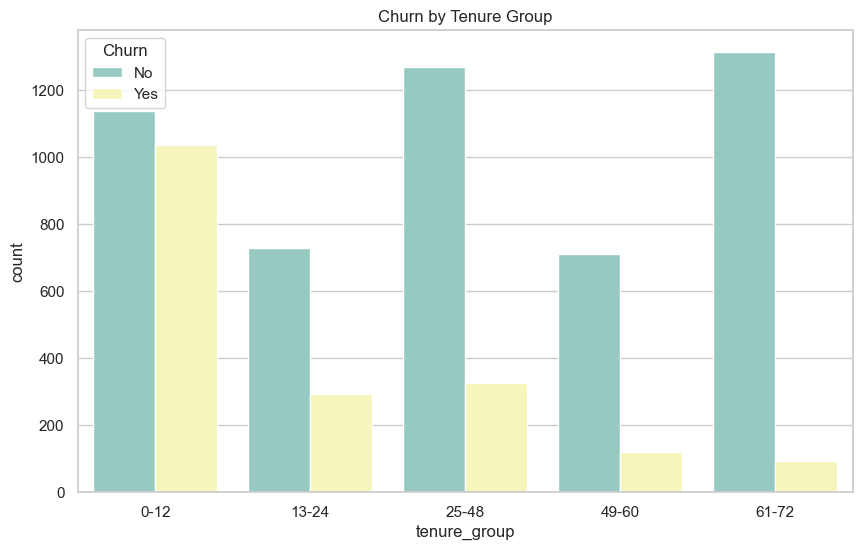

In [51]:
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

sns.countplot(data=df, x='tenure_group', hue='Churn', palette='Set3')
plt.title('Churn by Tenure Group')
plt.show()

## Pairplot

In [52]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')

Error in callback <function flush_figures at 0x000001741121F1C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Feature Engineering

#### Drop columns

In [18]:
df.drop(columns=['PhoneService', 'InternetService', 'customerID', 'Churn', 'tenure'], axis=1, inplace=True)

#### Label encoding

In [19]:
# Columns to label encode
cols_to_encode = [
    'gender', 'Partner', 'Dependents',
    'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod', 'tenure_group'
]

label_encoders = {}
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

## Modelling

#### Train-test split

In [20]:
X = df.drop(columns=['ChurnEncoded'])
y = df['ChurnEncoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

#### Evaluation Function

In [21]:
roc_curves = []
def evaluate_model(name, y_true, y_pred=None, y_proba=None):
    print(f"\n\n\n=================================== {name} ====================================================")
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision :", precision_score(y_true, y_pred))
    print("Recall :", recall_score(y_true, y_pred))
    print("F1-Score :", f1_score(y_true, y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=['No', 'Yes'])
    disp.plot(cmap='Blues', colorbar=True)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((name, fpr, tpr, roc_auc))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"======================================== End =====================================================")
    
    
    
def plot_all_roc_curves(roc_curves):
    plt.figure(figsize=(10, 8))
    for name, fpr, tpr, roc_auc in roc_curves:
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison Across Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [22]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

#### Logistic Regression

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

#### Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#### XGBoost

In [25]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [26]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
adaboost_model.fit(X_train, y_train)
ada_boost_y_pred = adaboost_model.predict(X_test)

In [27]:
#### Neural Networks
# Build deep learning model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)
y_proba_nn = nn_model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)

Epoch 1/50
141/141 [==============================] - 1s 5ms/step - loss: 29.9660 - accuracy: 0.6540 - val_loss: 3.5141 - val_accuracy: 0.7280
Epoch 2/50
141/141 [==============================] - 0s 3ms/step - loss: 9.4704 - accuracy: 0.6638 - val_loss: 1.3583 - val_accuracy: 0.6711
Epoch 3/50
141/141 [==============================] - 1s 4ms/step - loss: 4.9284 - accuracy: 0.6631 - val_loss: 0.8690 - val_accuracy: 0.4738
Epoch 4/50
141/141 [==============================] - 1s 4ms/step - loss: 2.7796 - accuracy: 0.6751 - val_loss: 0.6207 - val_accuracy: 0.6587
Epoch 5/50
141/141 [==============================] - 1s 4ms/step - loss: 1.9616 - accuracy: 0.6800 - val_loss: 0.6209 - val_accuracy: 0.6871
Epoch 6/50
141/141 [==============================] - 1s 4ms/step - loss: 1.4552 - accuracy: 0.6962 - val_loss: 0.5562 - val_accuracy: 0.7760
Epoch 7/50
141/141 [==============================] - 1s 4ms/step - loss: 1.9598 - accuracy: 0.6987 - val_loss: 0.8846 - val_accuracy: 0.7742
Epoch

#### Model Evaluation




=================================== Logistic Regression ====================================================
ROC AUC: 0.8226894823757189
Accuracy: 0.7867803837953091
Precision : 0.615625
Recall : 0.5267379679144385
F1-Score : 0.5677233429394812


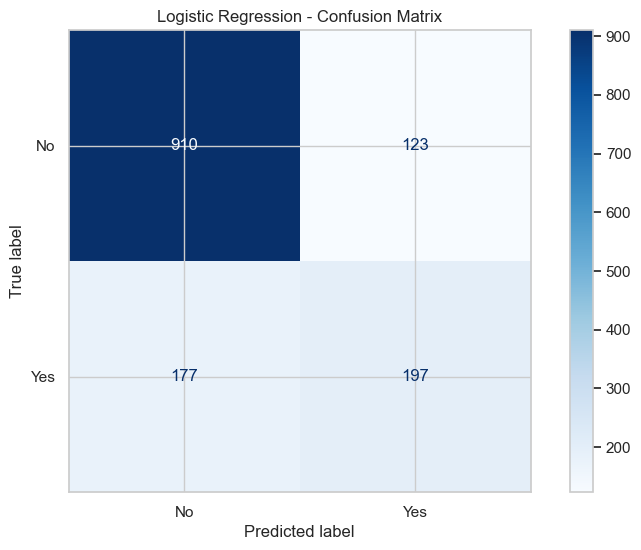

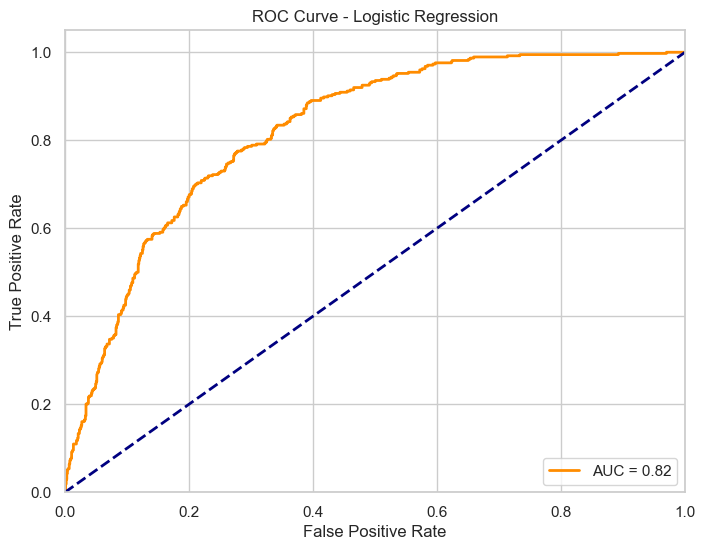

======================================== End =====================================================



=================================== Random Forest ====================================================
ROC AUC: 0.8126284483695793
Accuracy: 0.783226723525231
Precision : 0.6202090592334495
Recall : 0.47593582887700536
F1-Score : 0.5385779122541604


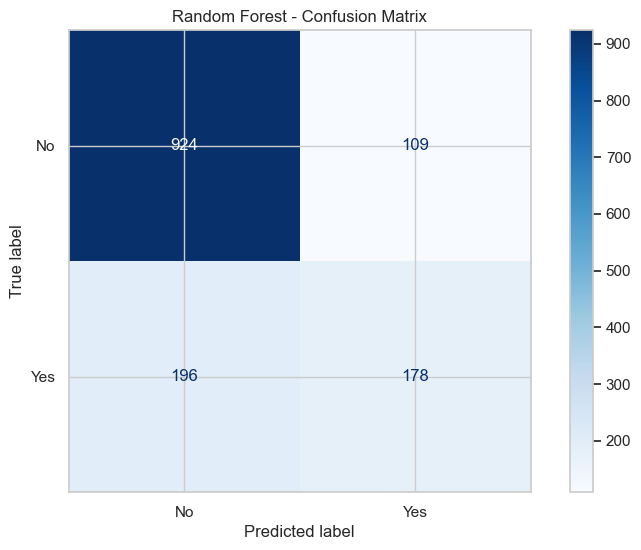

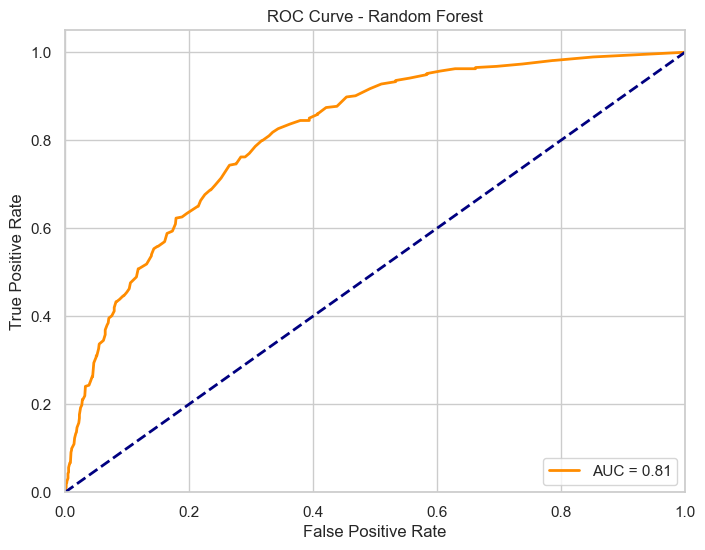

======================================== End =====================================================



=================================== XGBoost ====================================================
ROC AUC: 0.8068188289132427
Accuracy: 0.7725657427149965
Precision : 0.5789473684210527
Recall : 0.5294117647058824
F1-Score : 0.553072625698324


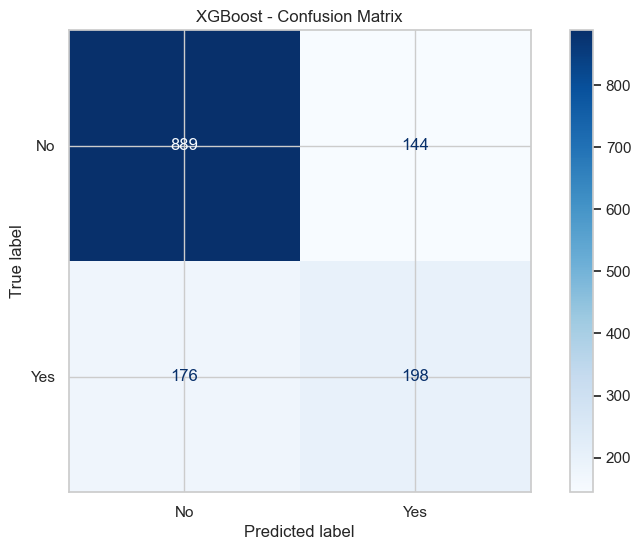

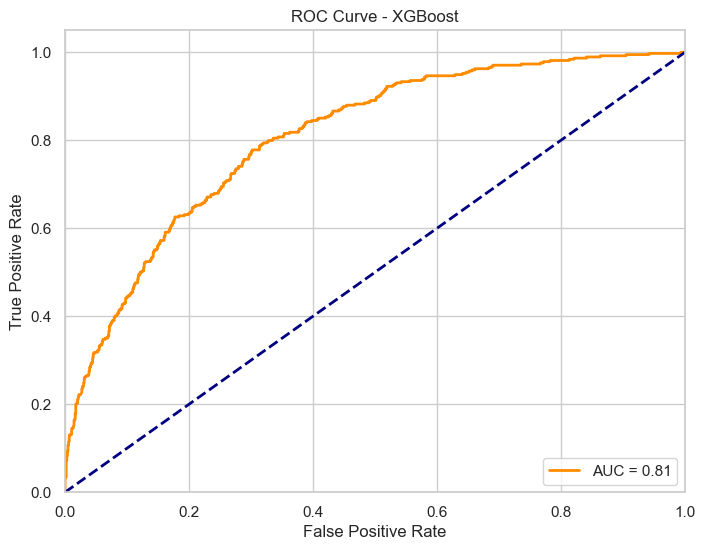

======================================== End =====================================================



=================================== Ada Boost ====================================================
ROC AUC: 0.8308881767967241
Accuracy: 0.7867803837953091
Precision : 0.6094674556213018
Recall : 0.5508021390374331
F1-Score : 0.5786516853932584


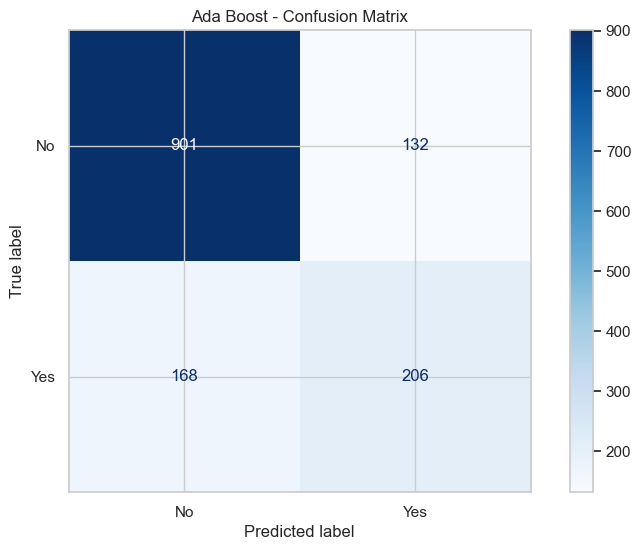

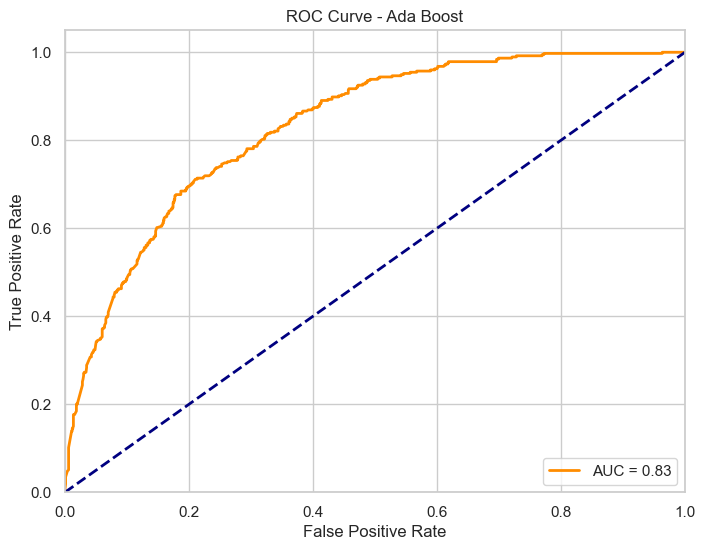

======================================== End =====================================================



=================================== Gradient Boosting ====================================================
ROC AUC: 0.8362577716116809
Accuracy: 0.7917555081734187
Precision : 0.6363636363636364
Recall : 0.5053475935828877
F1-Score : 0.563338301043219


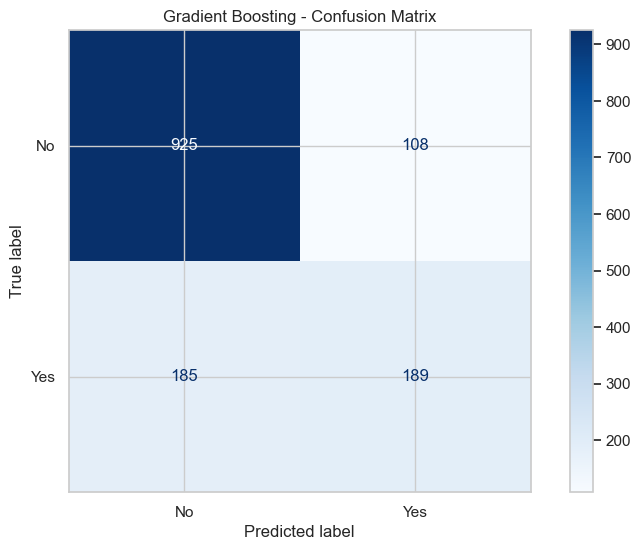

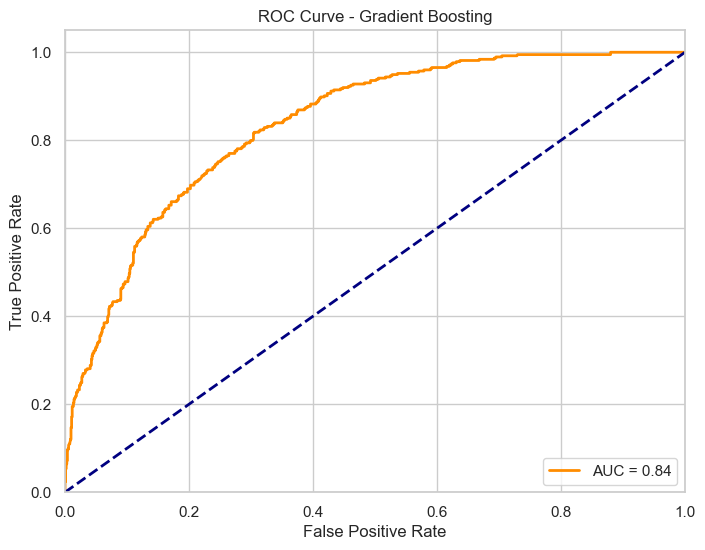

======================================== End =====================================================



=================================== Neural Network ====================================================
ROC AUC: 0.7378553198979143
Accuracy: 0.7761194029850746
Precision : 0.6439024390243903
Recall : 0.35294117647058826
F1-Score : 0.45595854922279794


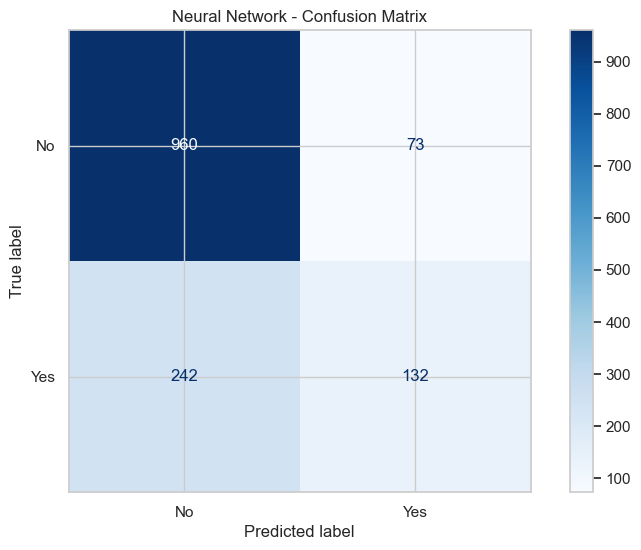

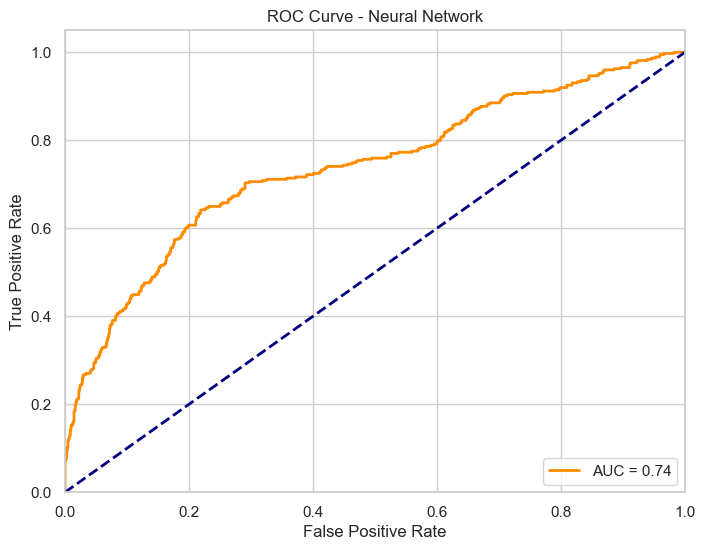

======================================== End =====================================================


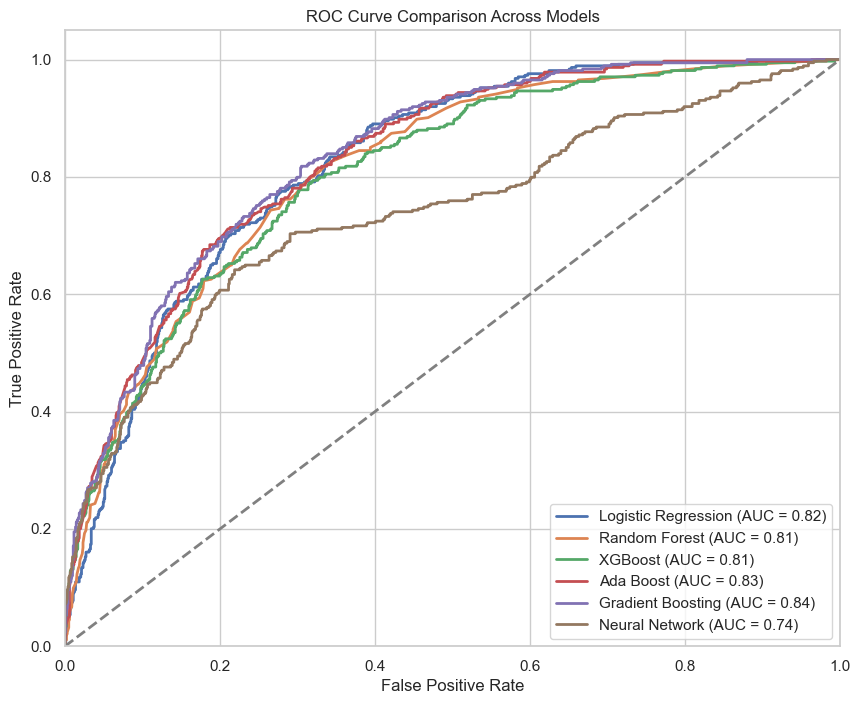

In [28]:
evaluate_model("Logistic Regression", y_test, y_pred=lr_pred, y_proba=lr.predict_proba(X_test)[:, 1])
evaluate_model("Random Forest", y_test, y_pred=rf_pred, y_proba=rf.predict_proba(X_test)[:, 1])
evaluate_model("XGBoost", y_test, y_pred=xgb_pred, y_proba=xgb_model.predict_proba(X_test)[:, 1])
evaluate_model("Ada Boost", y_test, y_pred=ada_boost_y_pred, y_proba=adaboost_model.predict_proba(X_test)[:, 1])
evaluate_model("Gradient Boosting", y_test, y_pred=gb_pred, y_proba=gb.predict_proba(X_test)[:, 1])
evaluate_model("Neural Network", y_test, y_pred=y_pred_nn, y_proba=y_proba_nn)
plot_all_roc_curves(roc_curves)

#### Hyper Parameter Tuning
- Based AUC ROC Logistic is the best model

In [29]:
def objective(trial):
    # Hyperparameters to tune for GradientBoosting
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Create the GradientBoosting model
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Cross-validation score (ROC AUC)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=300)
print("Best parameters:", study.best_params)

[I 2025-04-24 12:59:15,332] A new study created in memory with name: no-name-ea668e02-b8f9-4c6b-b003-63736e666dae
[I 2025-04-24 12:59:25,136] Trial 0 finished with value: 0.8072772842485444 and parameters: {'learning_rate': 0.27500009874184944, 'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8072772842485444.
[I 2025-04-24 12:59:35,604] Trial 1 finished with value: 0.8301230088997222 and parameters: {'learning_rate': 0.004819580135002008, 'n_estimators': 157, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8301230088997222.
[I 2025-04-24 12:59:44,514] Trial 2 finished with value: 0.835468105954473 and parameters: {'learning_rate': 0.016819897929533763, 'n_estimators': 128, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.835468105954473.
[I 2025-04-24 12:59:52,338] Trial 3 finished with value: 0.8357944560965931 and parameters: {

Best parameters: {'learning_rate': 0.032087901245956556, 'n_estimators': 182, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}





=================================== Optuna-Tuned Gradient Boosting ====================================================
ROC AUC: 0.8368453339269352
Accuracy: 0.7917555081734187
Precision : 0.6401384083044983
Recall : 0.4946524064171123
F1-Score : 0.5580693815987934


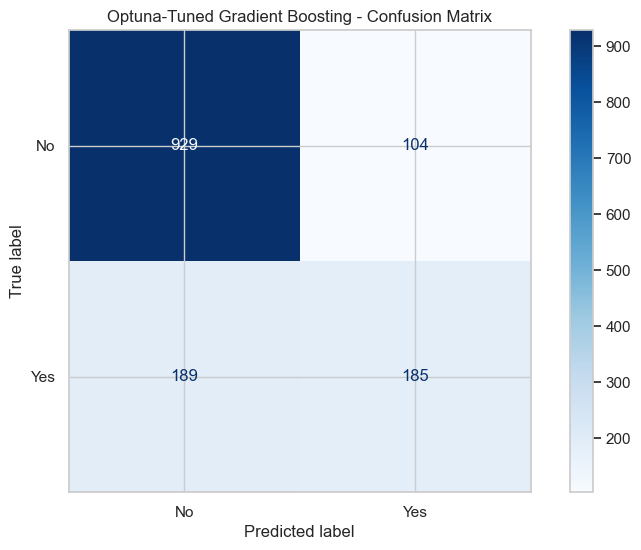

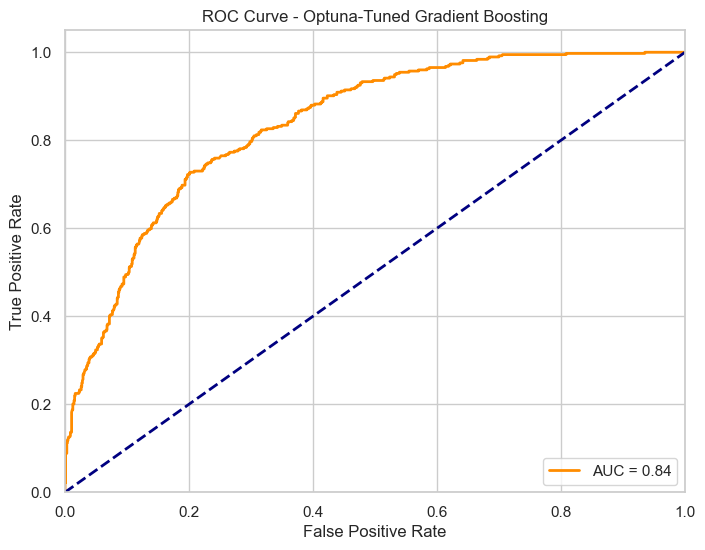

======================================== End =====================================================


In [30]:
# Train with best parameters
best_params = study.best_params
final_gb = GradientBoostingClassifier(**best_params)
final_gb.fit(X_train, y_train)
final_gb_pred = final_gb.predict(X_test)
final_gb_proba = final_gb.predict_proba(X_test)[:, 1]
evaluate_model("Optuna-Tuned Gradient Boosting", y_test, y_pred=final_gb_pred, y_proba=final_gb_proba)

#### Train and Evaluate the Best Model

## Feature Importance
- The shap values for logistic regression model are in log-odds, unless you explain predict_proba.

In [31]:
explainer = shap.TreeExplainer(final_gb, feature_names=X.columns)
shap_values = explainer(X_test)

#### Global Importance

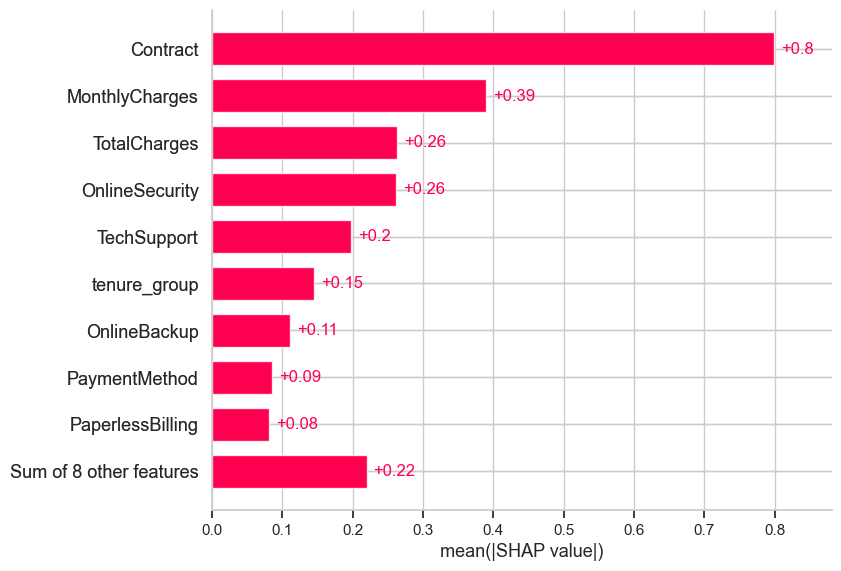

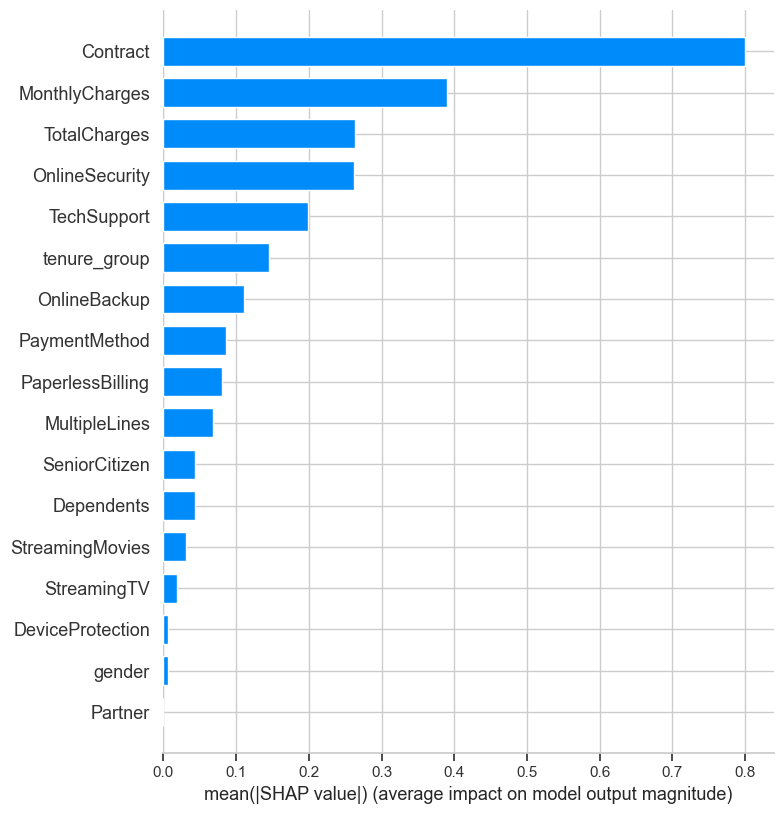

In [32]:
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### SHAP Beeswarm for Directional Impact

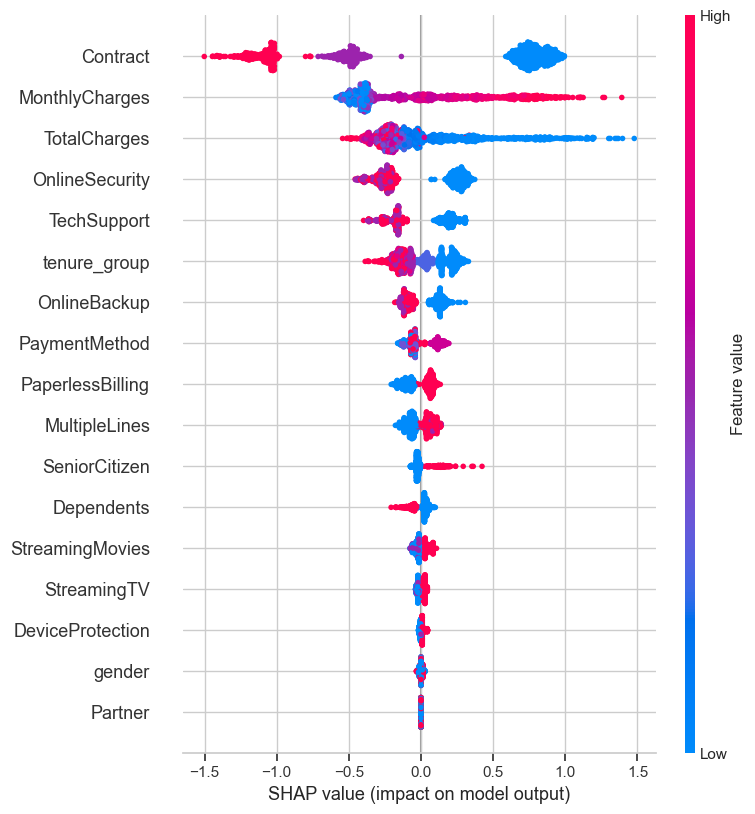

In [33]:
shap.summary_plot(shap_values, X_test)

#### Local Explanation (For One Customer)

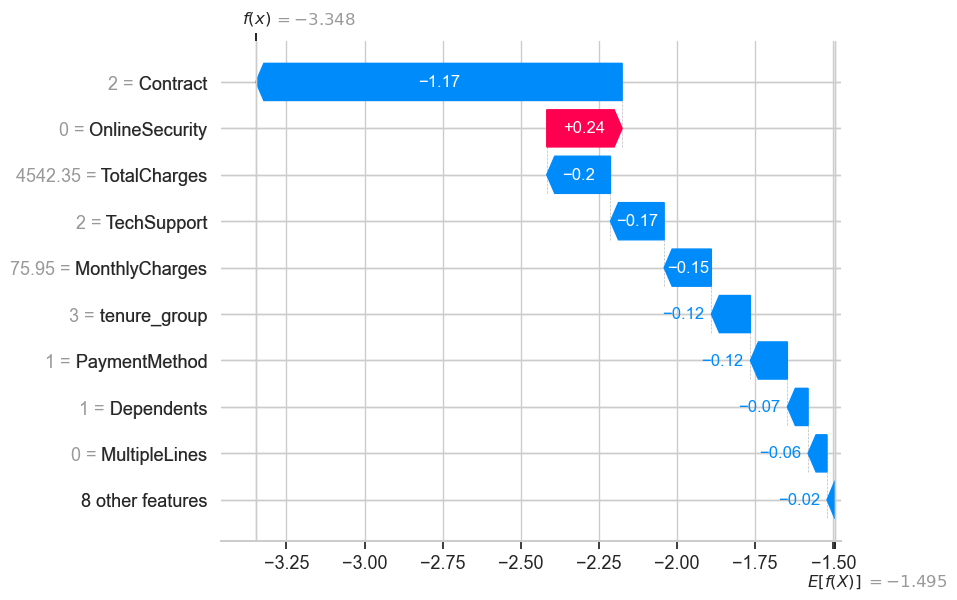

In [34]:
shap.plots.waterfall(shap_values[0])

<Figure size 1000x600 with 0 Axes>

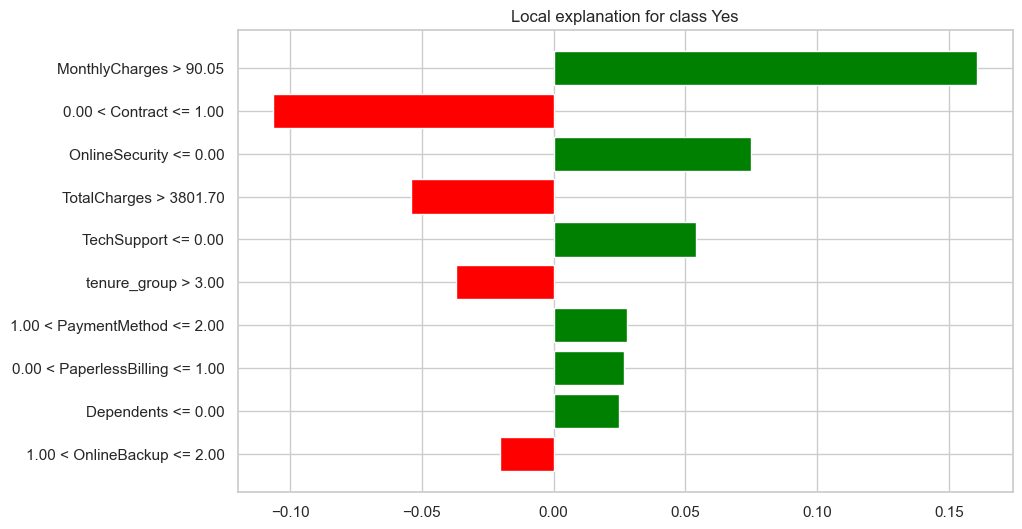

In [35]:
import matplotlib.pyplot as plt

plt.clf()

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

i = 29
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=final_gb.predict_proba
)

exp.as_pyplot_figure()
exp.show_in_notebook(show_all=True);